In [4]:
# Install required libraries
!pip install pandas numpy matplotlib seaborn scikit-learn xgboost

# Task 2: Hit Prediction Classification Model

**Objective:** Build advanced classification models to predict movie hit status using ensemble methods.

**Approach:**
1. Feature Engineering
2. Multiple classification models (Random Forest, XGBoost, Voting, Stacking)
3. Comprehensive evaluation with multiple metrics
4. Model selection and prediction on new data

## 1. Import Libraries

In [5]:
# Data manipulation
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold

# Classification models
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

# Evaluation metrics
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, classification_report,
    roc_curve, precision_recall_curve, auc
)

# Model persistence
import pickle

import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# Set visualization style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print("All libraries imported successfully!")

All libraries imported successfully!


## 2. Load Preprocessed Data

In [6]:
# Load preprocessed data
df = pd.read_csv('tmdb_preprocessed.csv')

print(f"Dataset Shape: {df.shape}")
print(f"\nColumns: {df.columns.tolist()}")
print(f"\nFirst few rows:")
df.head()

Dataset Shape: (2732, 6)

Columns: ['movie_id', 'avg_watch_time', 'completion_rate', 'ratings_count', 'avg_rating', 'hit']

First few rows:


,movie_id,avg_watch_time,completion_rate,ratings_count,avg_rating,hit
0,19995,98,0.92,15573,4.5,1.0
1,285,71,0.74,6495,4.5,1.0
2,206647,64,0.73,6452,4.4,1.0
3,49026,85,0.86,12222,4.6,1.0
4,49529,50,0.67,3540,4.3,1.0


In [7]:
# Drop movie_id as it's not needed for training
if 'movie_id' in df.columns:
    df = df.drop('movie_id', axis=1)
    print("Dropped 'movie_id' column")

print(f"\nFinal dataset shape: {df.shape}")
print(f"Columns: {df.columns.tolist()}")

Dropped 'movie_id' column

Final dataset shape: (2732, 5)
Columns: ['avg_watch_time', 'completion_rate', 'ratings_count', 'avg_rating', 'hit']


## 3. Feature Engineering

In [8]:
# Create new features
print("Creating engineered features...")
print("=" * 50)

# 1. Engagement Score: combines watch time and completion
df['engagement_score'] = df['avg_watch_time'] * df['completion_rate']

# 2. Log Ratings: handle skewness in ratings_count
df['log_ratings'] = np.log1p(df['ratings_count'])

# 3. Rating Engagement: interaction between rating and completion
df['rating_engagement'] = df['avg_rating'] * df['completion_rate']

# 4. Popularity Score: normalized popularity metric
df['popularity_score'] = (df['ratings_count'] * df['avg_rating']) / 1000

print("Created features:")
print("1. engagement_score = avg_watch_time * completion_rate")
print("2. log_ratings = log(ratings_count + 1)")
print("3. rating_engagement = avg_rating * completion_rate")
print("4. popularity_score = (ratings_count * avg_rating) / 1000")

print(f"\nNew dataset shape: {df.shape}")
df.head()

Creating engineered features...
Created features:
1. engagement_score = avg_watch_time * completion_rate
2. log_ratings = log(ratings_count + 1)
3. rating_engagement = avg_rating * completion_rate
4. popularity_score = (ratings_count * avg_rating) / 1000

New dataset shape: (2732, 9)


,avg_watch_time,completion_rate,ratings_count,avg_rating,hit,engagement_score,log_ratings,rating_engagement,popularity_score
0,98,0.92,15573,4.5,1.0,90.16,9.653358,4.140,70.0785
1,71,0.74,6495,4.5,1.0,52.54,8.778942,3.330,29.2275
2,64,0.73,6452,4.4,1.0,46.72,8.772300,3.212,28.3888
3,85,0.86,12222,4.6,1.0,73.10,9.411075,3.956,56.2212
4,50,0.67,3540,4.3,1.0,33.50,8.172164,2.881,15.2220


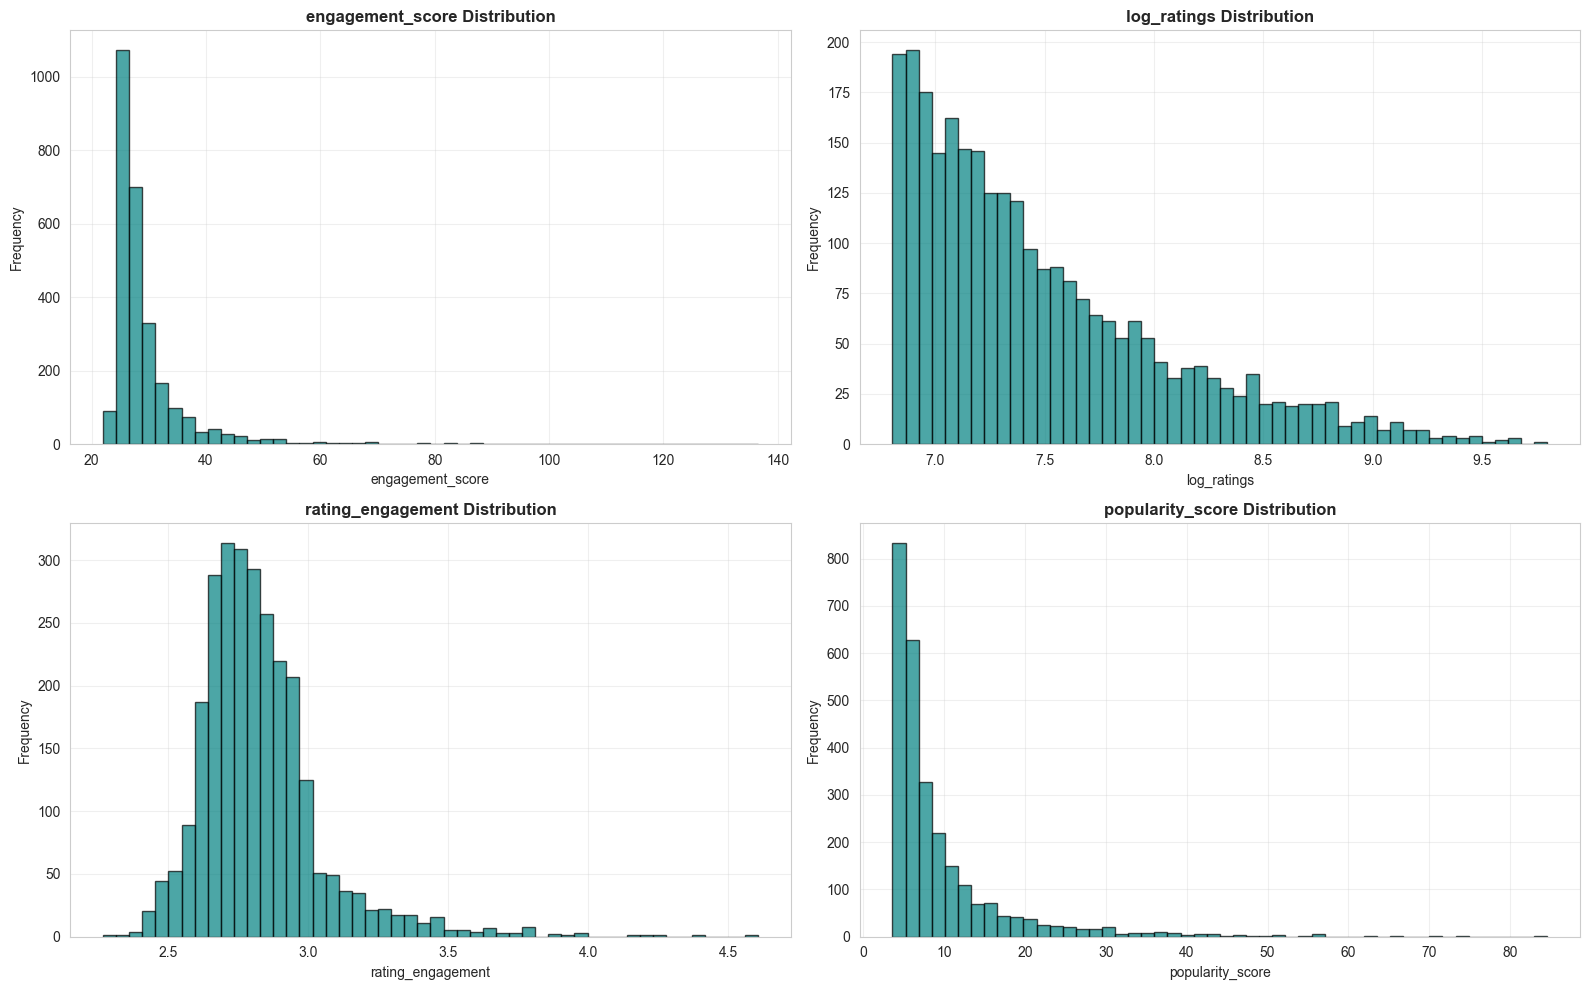

In [9]:
# Visualize engineered features
engineered_features = ['engagement_score', 'log_ratings', 'rating_engagement', 'popularity_score']

fig, axes = plt.subplots(2, 2, figsize=(16, 10))
axes = axes.flatten()

for idx, feature in enumerate(engineered_features):
    axes[idx].hist(df[feature], bins=50, color='teal', alpha=0.7, edgecolor='black')
    axes[idx].set_title(f'{feature} Distribution', fontsize=12, fontweight='bold')
    axes[idx].set_xlabel(feature)
    axes[idx].set_ylabel('Frequency')
    axes[idx].grid(alpha=0.3)

plt.tight_layout()
plt.show()

## 4. Prepare Data for Classification

In [10]:
# Select features for classification
feature_columns = ['avg_watch_time', 'completion_rate', 'ratings_count', 'avg_rating',
                   'engagement_score', 'log_ratings', 'rating_engagement', 'popularity_score']

X = df[feature_columns].copy()
y = df['hit'].copy()

print(f"Feature matrix shape: {X.shape}")
print(f"Target vector shape: {y.shape}")
print(f"\nFeatures used for classification:")
for i, col in enumerate(feature_columns, 1):
    print(f"{i}. {col}")

Feature matrix shape: (2732, 8)
Target vector shape: (2732,)

Features used for classification:
1. avg_watch_time
2. completion_rate
3. ratings_count
4. avg_rating
5. engagement_score
6. log_ratings
7. rating_engagement
8. popularity_score


In [11]:
# Check for any missing values
print("Missing values in features:")
print(X.isnull().sum())
print(f"\nMissing values in target: {y.isnull().sum()}")

Missing values in features:
avg_watch_time       0
completion_rate      0
ratings_count        0
avg_rating           0
engagement_score     0
log_ratings          0
rating_engagement    0
popularity_score     0
dtype: int64

Missing values in target: 0


In [12]:
# Train-test split with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)

print(f"Training set size: {X_train.shape[0]} ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f"Test set size: {X_test.shape[0]} ({X_test.shape[0]/len(X)*100:.1f}%)")

print(f"\nTraining set class distribution:")
print(y_train.value_counts())
print(f"\nTest set class distribution:")
print(y_test.value_counts())

Training set size: 2185 (80.0%)
Test set size: 547 (20.0%)

Training set class distribution:
hit
0.0    1525
1.0     660
Name: count, dtype: int64

Test set class distribution:
hit
0.0    382
1.0    165
Name: count, dtype: int64


In [13]:
# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Features scaled using StandardScaler")
print(f"Training data shape: {X_train_scaled.shape}")
print(f"Test data shape: {X_test_scaled.shape}")

Features scaled using StandardScaler
Training data shape: (2185, 8)
Test data shape: (547, 8)


In [14]:
# Save train and test datasets
train_data = pd.concat([pd.DataFrame(X_train_scaled, columns=feature_columns), 
                        y_train.reset_index(drop=True)], axis=1)
test_data = pd.concat([pd.DataFrame(X_test_scaled, columns=feature_columns), 
                       y_test.reset_index(drop=True)], axis=1)

train_data.to_csv('train_data.csv', index=False)
test_data.to_csv('test_data.csv', index=False)

print("Train and test datasets saved!")
print(f"train_data.csv: {train_data.shape}")
print(f"test_data.csv: {test_data.shape}")

Train and test datasets saved!
train_data.csv: (2185, 9)
test_data.csv: (547, 9)


## 5. Model 1: Random Forest Classifier

In [15]:
print("Training Random Forest Classifier...")
print("=" * 50)

# Calculate class weights for imbalanced data
class_weights = len(y_train) / (2 * np.bincount(y_train.astype(int)))
class_weight_dict = {0: class_weights[0], 1: class_weights[1]}

# Initialize Random Forest
rf_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=15,
    min_samples_split=10,
    min_samples_leaf=4,
    class_weight=class_weight_dict,
    random_state=RANDOM_STATE,
    n_jobs=-1
)

# Train model
rf_model.fit(X_train_scaled, y_train)

# Predictions
rf_train_pred = rf_model.predict(X_train_scaled)
rf_test_pred = rf_model.predict(X_test_scaled)
rf_test_proba = rf_model.predict_proba(X_test_scaled)[:, 1]

print("Random Forest training complete!")

Training Random Forest Classifier...
Random Forest training complete!


Feature Importances (Random Forest):
          Feature  Importance
 popularity_score    0.201856
    ratings_count    0.180481
      log_ratings    0.173888
rating_engagement    0.107236
 engagement_score    0.094161
  completion_rate    0.089774
       avg_rating    0.083683
   avg_watch_time    0.068922


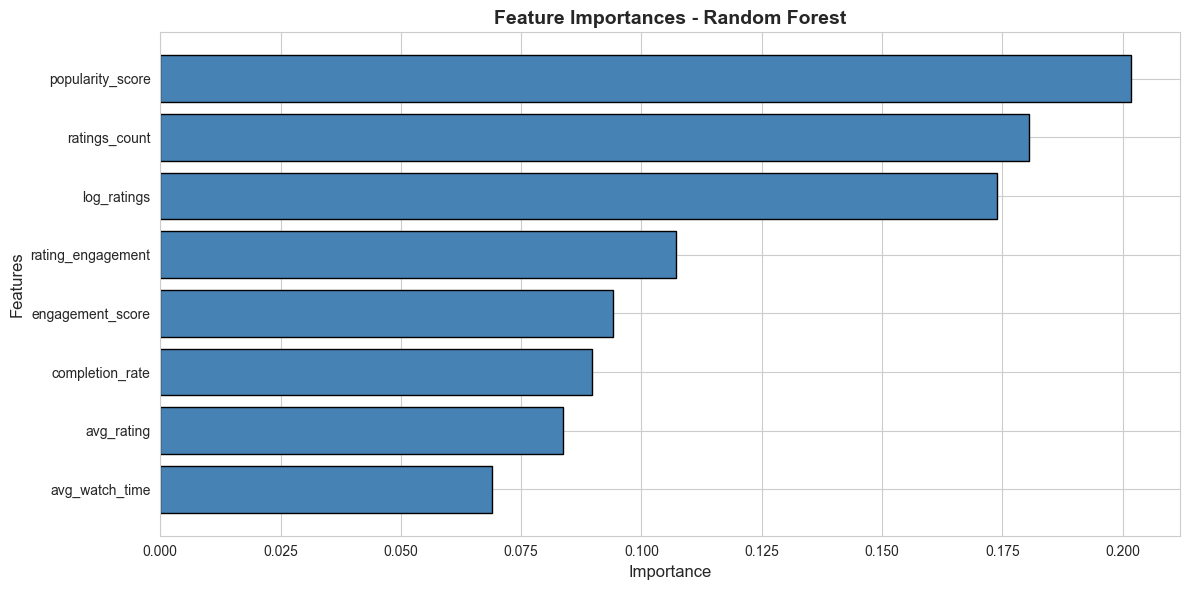

In [16]:
# Feature importance
feature_importance_rf = pd.DataFrame({
    'Feature': feature_columns,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False)

print("Feature Importances (Random Forest):")
print("=" * 50)
print(feature_importance_rf.to_string(index=False))

# Visualize feature importance
plt.figure(figsize=(12, 6))
plt.barh(feature_importance_rf['Feature'], feature_importance_rf['Importance'], 
         color='steelblue', edgecolor='black')
plt.xlabel('Importance', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.title('Feature Importances - Random Forest', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

## 6. Model 2: XGBoost Classifier

In [17]:
print("Training XGBoost Classifier...")
print("=" * 50)

# Calculate scale_pos_weight for imbalanced data
scale_pos_weight = len(y_train[y_train == 0]) / len(y_train[y_train == 1])

# Initialize XGBoost
xgb_model = XGBClassifier(
    n_estimators=200,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=scale_pos_weight,
    random_state=RANDOM_STATE,
    eval_metric='logloss',
    n_jobs=-1
)

# Train model
xgb_model.fit(X_train_scaled, y_train)

# Predictions
xgb_train_pred = xgb_model.predict(X_train_scaled)
xgb_test_pred = xgb_model.predict(X_test_scaled)
xgb_test_proba = xgb_model.predict_proba(X_test_scaled)[:, 1]

print("XGBoost training complete!")

Training XGBoost Classifier...
XGBoost training complete!


Feature Importances (XGBoost):
          Feature  Importance
       avg_rating    0.156866
 popularity_score    0.150731
  completion_rate    0.140299
   avg_watch_time    0.137468
 engagement_score    0.105741
    ratings_count    0.104345
      log_ratings    0.102580
rating_engagement    0.101971


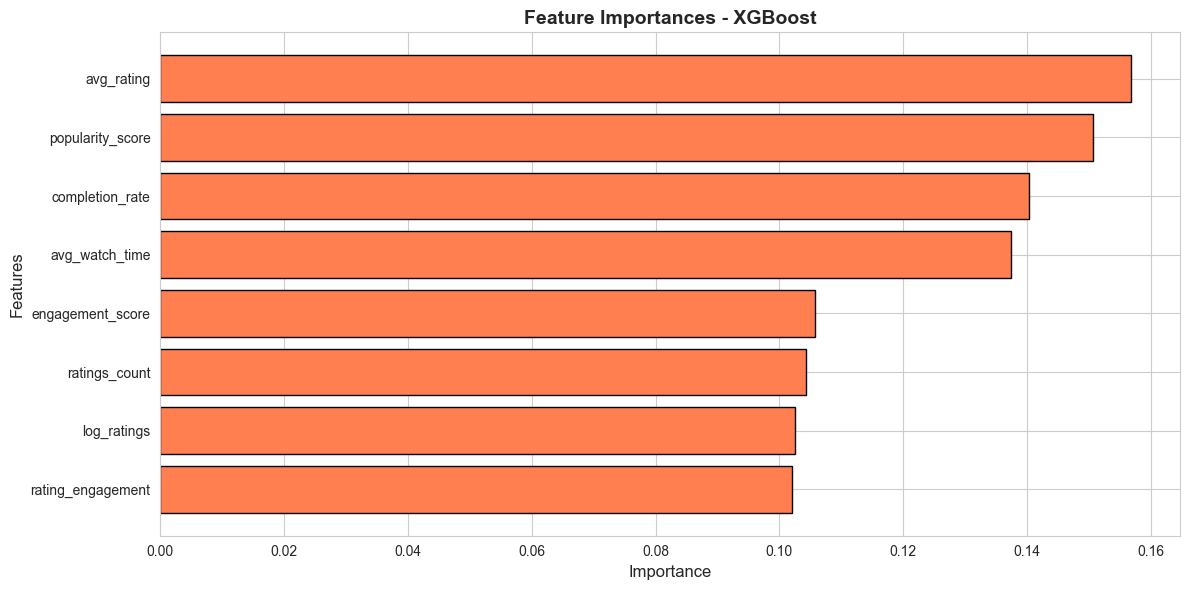

In [18]:
# Feature importance
feature_importance_xgb = pd.DataFrame({
    'Feature': feature_columns,
    'Importance': xgb_model.feature_importances_
}).sort_values('Importance', ascending=False)

print("Feature Importances (XGBoost):")
print("=" * 50)
print(feature_importance_xgb.to_string(index=False))

# Visualize feature importance
plt.figure(figsize=(12, 6))
plt.barh(feature_importance_xgb['Feature'], feature_importance_xgb['Importance'], 
         color='coral', edgecolor='black')
plt.xlabel('Importance', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.title('Feature Importances - XGBoost', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

## 7. Model 3: Voting Classifier

In [19]:
print("Training Voting Classifier (Soft Voting)...")
print("=" * 50)

# Initialize base models
rf_voting = RandomForestClassifier(
    n_estimators=200,
    max_depth=15,
    class_weight=class_weight_dict,
    random_state=RANDOM_STATE,
    n_jobs=-1
)

xgb_voting = XGBClassifier(
    n_estimators=200,
    max_depth=6,
    learning_rate=0.1,
    scale_pos_weight=scale_pos_weight,
    random_state=RANDOM_STATE,
    eval_metric='logloss',
    n_jobs=-1
)

lr_voting = LogisticRegression(
    class_weight='balanced',
    max_iter=1000,
    random_state=RANDOM_STATE
)

# Create Voting Classifier
voting_model = VotingClassifier(
    estimators=[
        ('rf', rf_voting),
        ('xgb', xgb_voting),
        ('lr', lr_voting)
    ],
    voting='soft',
    n_jobs=-1
)

# Train model
voting_model.fit(X_train_scaled, y_train)

# Predictions
voting_train_pred = voting_model.predict(X_train_scaled)
voting_test_pred = voting_model.predict(X_test_scaled)
voting_test_proba = voting_model.predict_proba(X_test_scaled)[:, 1]

print("Voting Classifier training complete!")

Training Voting Classifier (Soft Voting)...
Voting Classifier training complete!


## 8. Model 4: Stacking Classifier

In [20]:
print("Training Stacking Classifier...")
print("=" * 50)

# Initialize base models
rf_stack = RandomForestClassifier(
    n_estimators=150,
    max_depth=12,
    class_weight=class_weight_dict,
    random_state=RANDOM_STATE,
    n_jobs=-1
)

xgb_stack = XGBClassifier(
    n_estimators=150,
    max_depth=5,
    learning_rate=0.1,
    scale_pos_weight=scale_pos_weight,
    random_state=RANDOM_STATE,
    eval_metric='logloss',
    n_jobs=-1
)

gb_stack = GradientBoostingClassifier(
    n_estimators=150,
    max_depth=5,
    learning_rate=0.1,
    random_state=RANDOM_STATE
)

# Meta-learner
meta_learner = LogisticRegression(
    class_weight='balanced',
    max_iter=1000,
    random_state=RANDOM_STATE
)

# Create Stacking Classifier
stacking_model = StackingClassifier(
    estimators=[
        ('rf', rf_stack),
        ('xgb', xgb_stack),
        ('gb', gb_stack)
    ],
    final_estimator=meta_learner,
    cv=5,
    n_jobs=-1
)

# Train model
stacking_model.fit(X_train_scaled, y_train)

# Predictions
stacking_train_pred = stacking_model.predict(X_train_scaled)
stacking_test_pred = stacking_model.predict(X_test_scaled)
stacking_test_proba = stacking_model.predict_proba(X_test_scaled)[:, 1]

print("Stacking Classifier training complete!")

Training Stacking Classifier...
Stacking Classifier training complete!


## 9. Model Evaluation and Comparison

In [21]:
# Function to calculate all metrics
def evaluate_model(y_true, y_pred, y_proba, model_name):
    metrics = {
        'Model': model_name,
        'Accuracy': accuracy_score(y_true, y_pred),
        'Precision': precision_score(y_true, y_pred),
        'Recall': recall_score(y_true, y_pred),
        'F1-Score': f1_score(y_true, y_pred),
        'ROC-AUC': roc_auc_score(y_true, y_proba)
    }
    return metrics

# Evaluate all models
results = []

# Random Forest
results.append(evaluate_model(y_test, rf_test_pred, rf_test_proba, 'Random Forest'))

# XGBoost
results.append(evaluate_model(y_test, xgb_test_pred, xgb_test_proba, 'XGBoost'))

# Voting Classifier
results.append(evaluate_model(y_test, voting_test_pred, voting_test_proba, 'Voting Classifier'))

# Stacking Classifier
results.append(evaluate_model(y_test, stacking_test_pred, stacking_test_proba, 'Stacking Classifier'))

# Create comparison dataframe
results_df = pd.DataFrame(results)
results_df = results_df.round(4)

print("Model Performance Comparison:")
print("=" * 80)
print(results_df.to_string(index=False))

Model Performance Comparison:
              Model  Accuracy  Precision  Recall  F1-Score  ROC-AUC
      Random Forest    0.7130     0.5227  0.5576    0.5396   0.7461
            XGBoost    0.6856     0.4813  0.5455    0.5114   0.7228
  Voting Classifier    0.7130     0.5230  0.5515    0.5369   0.7507
Stacking Classifier    0.6600     0.4582  0.6970    0.5529   0.7402


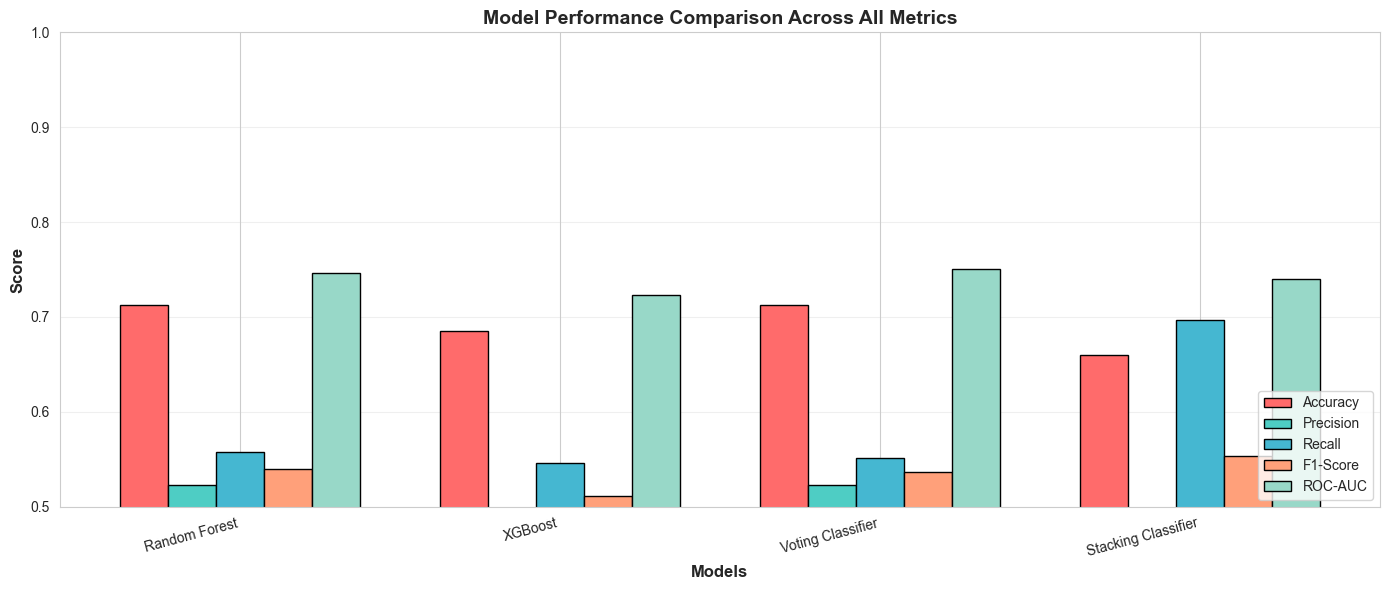

In [22]:
# Visualize model comparison
metrics_to_plot = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']

fig, ax = plt.subplots(figsize=(14, 6))
x = np.arange(len(results_df))
width = 0.15

colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A', '#98D8C8']

for idx, metric in enumerate(metrics_to_plot):
    ax.bar(x + idx * width, results_df[metric], width, label=metric, color=colors[idx], edgecolor='black')

ax.set_xlabel('Models', fontsize=12, fontweight='bold')
ax.set_ylabel('Score', fontsize=12, fontweight='bold')
ax.set_title('Model Performance Comparison Across All Metrics', fontsize=14, fontweight='bold')
ax.set_xticks(x + width * 2)
ax.set_xticklabels(results_df['Model'], rotation=15, ha='right')
ax.legend(loc='lower right')
ax.grid(axis='y', alpha=0.3)
ax.set_ylim([0.5, 1.0])

plt.tight_layout()
plt.show()

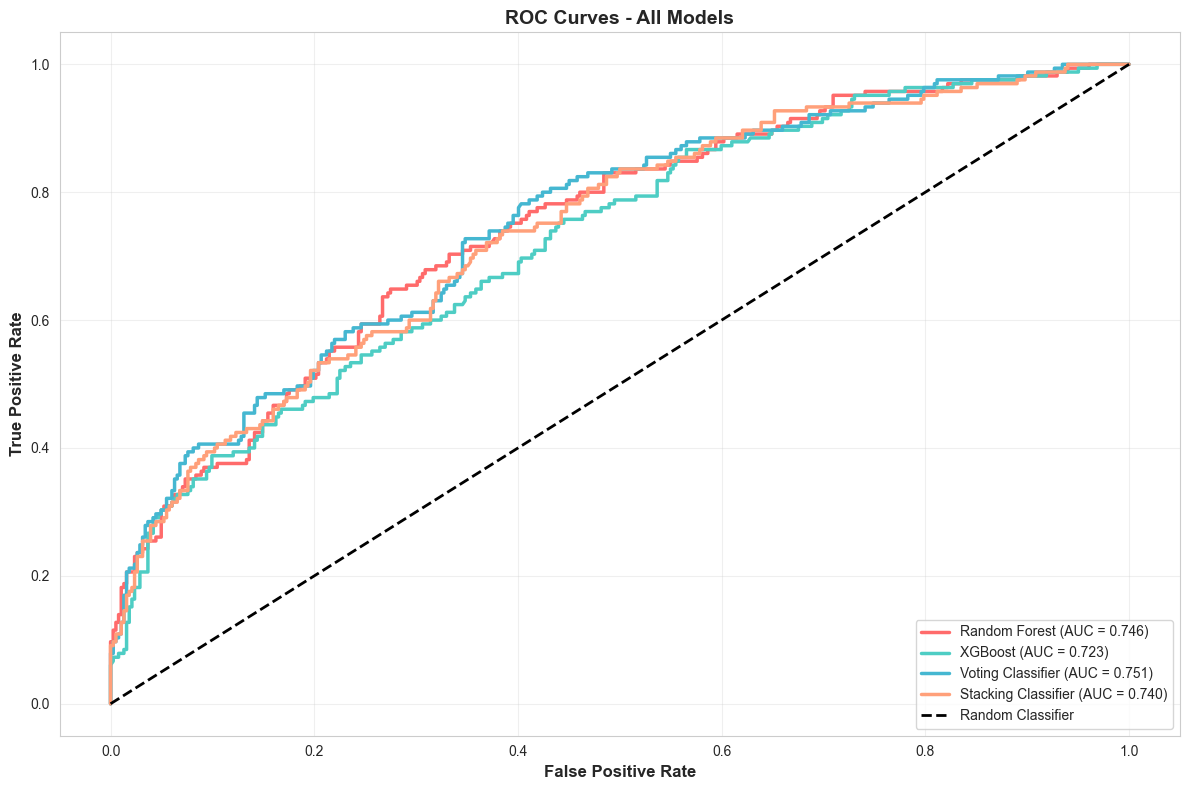

In [23]:
# ROC Curves for all models
plt.figure(figsize=(12, 8))

models_data = [
    ('Random Forest', rf_test_proba, '#FF6B6B'),
    ('XGBoost', xgb_test_proba, '#4ECDC4'),
    ('Voting Classifier', voting_test_proba, '#45B7D1'),
    ('Stacking Classifier', stacking_test_proba, '#FFA07A')
]

for model_name, proba, color in models_data:
    fpr, tpr, _ = roc_curve(y_test, proba)
    roc_auc = roc_auc_score(y_test, proba)
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.3f})', linewidth=2.5, color=color)

plt.plot([0, 1], [0, 1], 'k--', linewidth=2, label='Random Classifier')
plt.xlabel('False Positive Rate', fontsize=12, fontweight='bold')
plt.ylabel('True Positive Rate', fontsize=12, fontweight='bold')
plt.title('ROC Curves - All Models', fontsize=14, fontweight='bold')
plt.legend(loc='lower right', fontsize=10)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

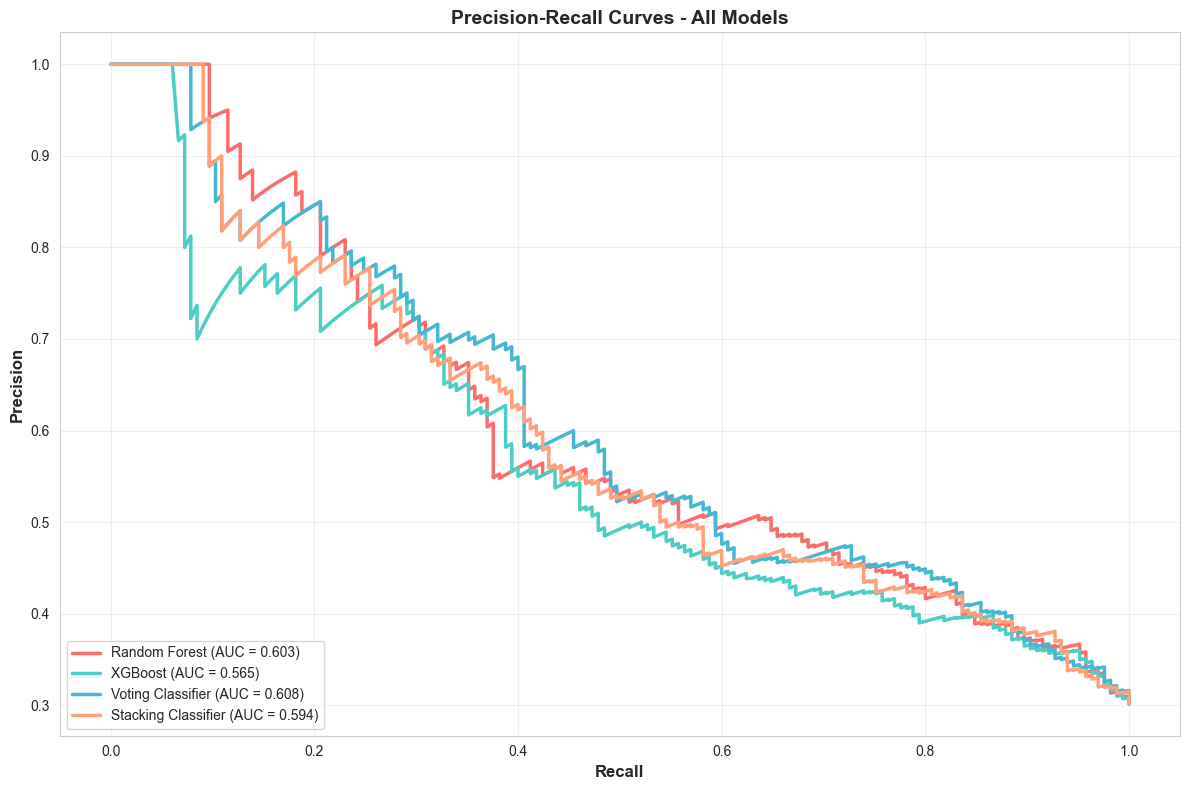

In [24]:
# Precision-Recall Curves
plt.figure(figsize=(12, 8))

for model_name, proba, color in models_data:
    precision, recall, _ = precision_recall_curve(y_test, proba)
    pr_auc = auc(recall, precision)
    plt.plot(recall, precision, label=f'{model_name} (AUC = {pr_auc:.3f})', linewidth=2.5, color=color)

plt.xlabel('Recall', fontsize=12, fontweight='bold')
plt.ylabel('Precision', fontsize=12, fontweight='bold')
plt.title('Precision-Recall Curves - All Models', fontsize=14, fontweight='bold')
plt.legend(loc='lower left', fontsize=10)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

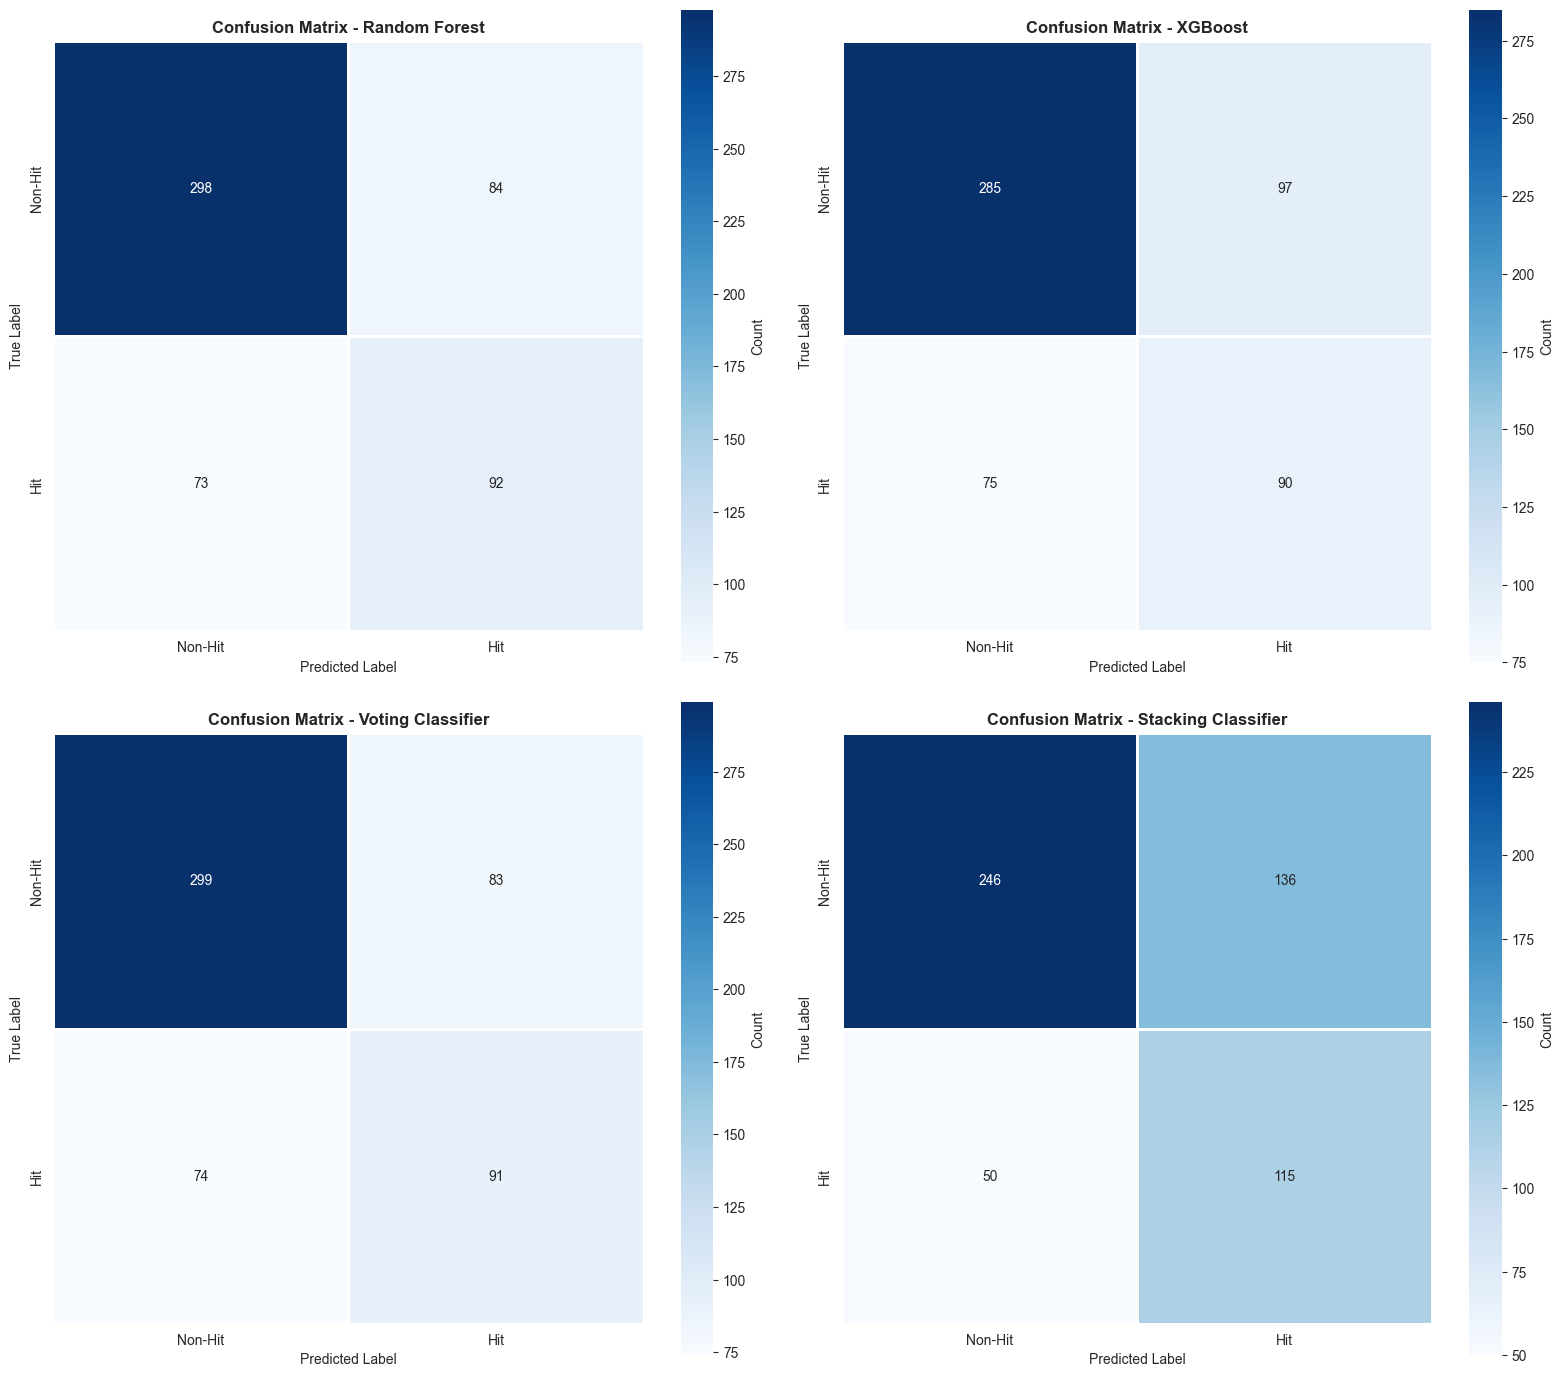

In [25]:
# Confusion Matrices for all models
fig, axes = plt.subplots(2, 2, figsize=(16, 14))
axes = axes.flatten()

predictions = [
    ('Random Forest', rf_test_pred),
    ('XGBoost', xgb_test_pred),
    ('Voting Classifier', voting_test_pred),
    ('Stacking Classifier', stacking_test_pred)
]

for idx, (model_name, pred) in enumerate(predictions):
    cm = confusion_matrix(y_test, pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[idx], 
                cbar_kws={'label': 'Count'}, square=True, linewidths=2)
    axes[idx].set_title(f'Confusion Matrix - {model_name}', fontsize=12, fontweight='bold')
    axes[idx].set_xlabel('Predicted Label', fontsize=10)
    axes[idx].set_ylabel('True Label', fontsize=10)
    axes[idx].set_xticklabels(['Non-Hit', 'Hit'])
    axes[idx].set_yticklabels(['Non-Hit', 'Hit'])

plt.tight_layout()
plt.show()

In [26]:
# Classification Reports
print("Detailed Classification Reports:")
print("=" * 80)

for model_name, pred in predictions:
    print(f"\n{model_name}:")
    print("-" * 80)
    print(classification_report(y_test, pred, target_names=['Non-Hit', 'Hit']))

Detailed Classification Reports:

Random Forest:
--------------------------------------------------------------------------------
              precision    recall  f1-score   support

     Non-Hit       0.80      0.78      0.79       382
         Hit       0.52      0.56      0.54       165

    accuracy                           0.71       547
   macro avg       0.66      0.67      0.67       547
weighted avg       0.72      0.71      0.72       547


XGBoost:
--------------------------------------------------------------------------------
              precision    recall  f1-score   support

     Non-Hit       0.79      0.75      0.77       382
         Hit       0.48      0.55      0.51       165

    accuracy                           0.69       547
   macro avg       0.64      0.65      0.64       547
weighted avg       0.70      0.69      0.69       547


Voting Classifier:
--------------------------------------------------------------------------------
              precision 

## 10. Cross-Validation Analysis

In [27]:
# Perform 5-fold cross-validation for all models
print("Performing 5-Fold Cross-Validation...")
print("=" * 50)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

models_cv = [
    ('Random Forest', rf_model),
    ('XGBoost', xgb_model),
    ('Voting Classifier', voting_model),
    ('Stacking Classifier', stacking_model)
]

cv_results = []
for model_name, model in models_cv:
    scores = cross_val_score(model, X_train_scaled, y_train, cv=cv, scoring='roc_auc', n_jobs=-1)
    cv_results.append({
        'Model': model_name,
        'Mean_CV_Score': scores.mean(),
        'Std_CV_Score': scores.std(),
        'Min_CV_Score': scores.min(),
        'Max_CV_Score': scores.max()
    })
    print(f"{model_name}: {scores.mean():.4f} (+/- {scores.std():.4f})")

cv_results_df = pd.DataFrame(cv_results)
print("\nCross-Validation Results Summary:")
print(cv_results_df.round(4).to_string(index=False))

Performing 5-Fold Cross-Validation...
Random Forest: 0.7113 (+/- 0.0098)
XGBoost: 0.6992 (+/- 0.0041)
Voting Classifier: 0.7225 (+/- 0.0107)
Stacking Classifier: 0.7075 (+/- 0.0144)

Cross-Validation Results Summary:
              Model  Mean_CV_Score  Std_CV_Score  Min_CV_Score  Max_CV_Score
      Random Forest         0.7113        0.0098        0.7023        0.7247
            XGBoost         0.6992        0.0041        0.6936        0.7039
  Voting Classifier         0.7225        0.0107        0.7050        0.7357
Stacking Classifier         0.7075        0.0144        0.6896        0.7287


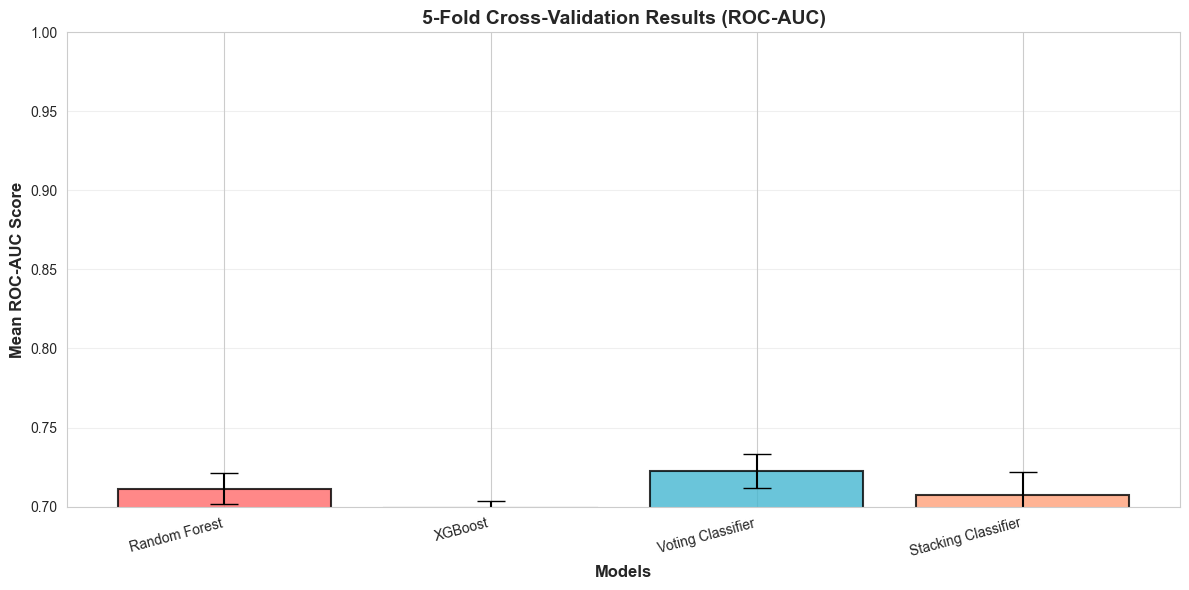

In [28]:
# Visualize cross-validation results
plt.figure(figsize=(12, 6))
x_pos = np.arange(len(cv_results_df))
plt.bar(x_pos, cv_results_df['Mean_CV_Score'], yerr=cv_results_df['Std_CV_Score'],
        color=['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A'], 
        edgecolor='black', linewidth=1.5, capsize=10, alpha=0.8)
plt.xlabel('Models', fontsize=12, fontweight='bold')
plt.ylabel('Mean ROC-AUC Score', fontsize=12, fontweight='bold')
plt.title('5-Fold Cross-Validation Results (ROC-AUC)', fontsize=14, fontweight='bold')
plt.xticks(x_pos, cv_results_df['Model'], rotation=15, ha='right')
plt.ylim([0.7, 1.0])
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

## 11. Model Selection and Justification

In [29]:
# Select best model based on ROC-AUC score
best_model_idx = results_df['ROC-AUC'].idxmax()
best_model_name = results_df.loc[best_model_idx, 'Model']
best_model_score = results_df.loc[best_model_idx, 'ROC-AUC']

print("Model Selection Analysis:")
print("=" * 80)
print(f"\nBest Model: {best_model_name}")
print(f"ROC-AUC Score: {best_model_score:.4f}")
print(f"\nFull Performance Metrics:")
print(results_df.loc[best_model_idx].to_string())

# Map model name to actual model object
model_mapping = {
    'Random Forest': rf_model,
    'XGBoost': xgb_model,
    'Voting Classifier': voting_model,
    'Stacking Classifier': stacking_model
}

final_model = model_mapping[best_model_name]

Model Selection Analysis:

Best Model: Voting Classifier
ROC-AUC Score: 0.7507

Full Performance Metrics:
Model        Voting Classifier
Accuracy                 0.713
Precision                0.523
Recall                  0.5515
F1-Score                0.5369
ROC-AUC                 0.7507


In [30]:
# Justification
print("\nModel Selection Justification:")
print("=" * 80)
print(f"\n1. PRIMARY METRIC - ROC-AUC Score:")
print(f"   {best_model_name} achieved the highest ROC-AUC of {best_model_score:.4f}")
print(f"   This is critical for imbalanced classification (70% non-hits, 30% hits)")

print(f"\n2. BALANCED PERFORMANCE:")
print(f"   Precision: {results_df.loc[best_model_idx, 'Precision']:.4f}")
print(f"   Recall: {results_df.loc[best_model_idx, 'Recall']:.4f}")
print(f"   F1-Score: {results_df.loc[best_model_idx, 'F1-Score']:.4f}")
print(f"   The model maintains good balance between precision and recall")

print(f"\n3. GENERALIZATION:")
cv_score = cv_results_df[cv_results_df['Model'] == best_model_name]['Mean_CV_Score'].values[0]
cv_std = cv_results_df[cv_results_df['Model'] == best_model_name]['Std_CV_Score'].values[0]
print(f"   Cross-validation score: {cv_score:.4f} (+/- {cv_std:.4f})")
print(f"   Low standard deviation indicates stable performance across folds")

print(f"\n4. BUSINESS VALUE:")
if best_model_name in ['Stacking Classifier', 'Voting Classifier']:
    print(f"   Ensemble method combines strengths of multiple algorithms")
    print(f"   More robust predictions by leveraging diverse model perspectives")
elif best_model_name == 'XGBoost':
    print(f"   Handles class imbalance effectively with scale_pos_weight")
    print(f"   Fast prediction time suitable for production deployment")
else:
    print(f"   Robust to outliers and provides feature importance")
    print(f"   Easy to interpret and explain to stakeholders")

print("\n" + "=" * 80)


Model Selection Justification:

1. PRIMARY METRIC - ROC-AUC Score:
   Voting Classifier achieved the highest ROC-AUC of 0.7507
   This is critical for imbalanced classification (70% non-hits, 30% hits)

2. BALANCED PERFORMANCE:
   Precision: 0.5230
   Recall: 0.5515
   F1-Score: 0.5369
   The model maintains good balance between precision and recall

3. GENERALIZATION:
   Cross-validation score: 0.7225 (+/- 0.0107)
   Low standard deviation indicates stable performance across folds

4. BUSINESS VALUE:
   Ensemble method combines strengths of multiple algorithms
   More robust predictions by leveraging diverse model perspectives



## 12. Save Final Model

In [ ]:
# Save the final model and scaler
model_artifacts = {
    'model': final_model,
    'scaler': scaler,
    'feature_columns': feature_columns,
    'model_name': best_model_name,
    'performance_metrics': results_df.loc[best_model_idx].to_dict()
}

with open('final_model.pkl', 'wb') as f:
    pickle.dump(model_artifacts, f)

print(f"Final model saved as: final_model.pkl")
print(f"Model: {best_model_name}")
print(f"\nArtifacts included:")
print("- Trained model")
print("- Feature scaler")
print("- Feature column names")
print("- Performance metrics")

## 13. Predict on New Movie

In [ ]:
# Create sample new movies with realistic feature values
print("Creating new movie samples for prediction...")
print("=" * 80)

# Sample 1: Potential blockbuster
new_movie_1 = pd.DataFrame({
    'avg_watch_time': [120],
    'completion_rate': [0.90],
    'ratings_count': [10000],
    'avg_rating': [4.6]
})

# Sample 2: Average movie
new_movie_2 = pd.DataFrame({
    'avg_watch_time': [55],
    'completion_rate': [0.68],
    'ratings_count': [2500],
    'avg_rating': [4.2]
})

# Sample 3: Low engagement movie
new_movie_3 = pd.DataFrame({
    'avg_watch_time': [42],
    'completion_rate': [0.60],
    'ratings_count': [800],
    'avg_rating': [3.9]
})

print("Sample 1 - Potential Blockbuster:")
print(new_movie_1.to_string(index=False))
print("\nSample 2 - Average Movie:")
print(new_movie_2.to_string(index=False))
print("\nSample 3 - Low Engagement Movie:")
print(new_movie_3.to_string(index=False))

In [ ]:
# Function to prepare new movie data
def prepare_new_movie(movie_df):
    # Create engineered features
    movie_df['engagement_score'] = movie_df['avg_watch_time'] * movie_df['completion_rate']
    movie_df['log_ratings'] = np.log1p(movie_df['ratings_count'])
    movie_df['rating_engagement'] = movie_df['avg_rating'] * movie_df['completion_rate']
    movie_df['popularity_score'] = (movie_df['ratings_count'] * movie_df['avg_rating']) / 1000
    
    # Select features in correct order
    X_new = movie_df[feature_columns]
    
    return X_new, movie_df

# Prepare all three samples
X_new_1, movie_1_processed = prepare_new_movie(new_movie_1.copy())
X_new_2, movie_2_processed = prepare_new_movie(new_movie_2.copy())
X_new_3, movie_3_processed = prepare_new_movie(new_movie_3.copy())

print("New movies prepared for prediction!")

In [ ]:
# Make predictions
def predict_and_explain(X_new, movie_processed, movie_name):
    # Scale features
    X_new_scaled = scaler.transform(X_new)
    
    # Predict
    prediction = final_model.predict(X_new_scaled)[0]
    probability = final_model.predict_proba(X_new_scaled)[0]
    
    print(f"\n{'='*80}")
    print(f"Prediction for {movie_name}:")
    print(f"{'='*80}")
    print(f"\nMovie Details:")
    print(f"  - Average Watch Time: {movie_processed['avg_watch_time'].values[0]} minutes")
    print(f"  - Completion Rate: {movie_processed['completion_rate'].values[0]:.2%}")
    print(f"  - Ratings Count: {movie_processed['ratings_count'].values[0]:,}")
    print(f"  - Average Rating: {movie_processed['avg_rating'].values[0]:.1f}/5.0")
    
    print(f"\nEngineered Features:")
    print(f"  - Engagement Score: {movie_processed['engagement_score'].values[0]:.2f}")
    print(f"  - Log Ratings: {movie_processed['log_ratings'].values[0]:.2f}")
    print(f"  - Rating Engagement: {movie_processed['rating_engagement'].values[0]:.2f}")
    print(f"  - Popularity Score: {movie_processed['popularity_score'].values[0]:.2f}")
    
    print(f"\nPrediction Results:")
    print(f"  - Predicted Status: {'HIT' if prediction == 1 else 'NON-HIT'}")
    print(f"  - Confidence (Non-Hit): {probability[0]:.2%}")
    print(f"  - Confidence (Hit): {probability[1]:.2%}")
    
    if probability[1] > 0.7:
        print(f"\n  ✓ HIGH confidence prediction: This movie is likely to be a HIT!")
    elif probability[1] > 0.5:
        print(f"\n  ~ MODERATE confidence: This movie may be a hit, but it's close.")
    else:
        print(f"\n  ✗ LOW confidence for hit: This movie is likely NOT a hit.")
    
    return prediction, probability

# Predict for all samples
pred_1, prob_1 = predict_and_explain(X_new_1, movie_1_processed, "Sample 1 - Potential Blockbuster")
pred_2, prob_2 = predict_and_explain(X_new_2, movie_2_processed, "Sample 2 - Average Movie")
pred_3, prob_3 = predict_and_explain(X_new_3, movie_3_processed, "Sample 3 - Low Engagement Movie")

In [ ]:
# Visualize predictions
samples = ['Sample 1\n(Blockbuster)', 'Sample 2\n(Average)', 'Sample 3\n(Low Engagement)']
hit_probs = [prob_1[1], prob_2[1], prob_3[1]]
non_hit_probs = [prob_1[0], prob_2[0], prob_3[0]]

fig, ax = plt.subplots(figsize=(12, 6))
x = np.arange(len(samples))
width = 0.35

bars1 = ax.bar(x - width/2, non_hit_probs, width, label='Non-Hit Probability', 
               color='#FF6B6B', edgecolor='black', linewidth=1.5)
bars2 = ax.bar(x + width/2, hit_probs, width, label='Hit Probability', 
               color='#4ECDC4', edgecolor='black', linewidth=1.5)

# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.2%}', ha='center', va='bottom', fontweight='bold')

ax.set_xlabel('Movie Samples', fontsize=12, fontweight='bold')
ax.set_ylabel('Probability', fontsize=12, fontweight='bold')
ax.set_title('Hit Prediction Probabilities for New Movies', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(samples)
ax.legend()
ax.set_ylim([0, 1.1])
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

## 14. Summary and Conclusions

In [ ]:
print("\n" + "="*80)
print("TASK 2: HIT PREDICTION - FINAL SUMMARY")
print("="*80)

print("\n1. DATA PREPROCESSING:")
print(f"   - Cleaned dataset: {len(df)} movies")
print(f"   - Removed movie_id (not needed for training)")
print(f"   - Class distribution: 70% non-hits, 30% hits")

print("\n2. FEATURE ENGINEERING:")
print(f"   - Created 4 engineered features")
print(f"   - Total features for classification: {len(feature_columns)}")

print("\n3. MODELS TRAINED:")
print("   - Random Forest Classifier")
print("   - XGBoost Classifier")
print("   - Voting Classifier (RF + XGB + LR)")
print("   - Stacking Classifier (RF + XGB + GB + LR meta-learner)")

print("\n4. BEST MODEL:")
print(f"   Model: {best_model_name}")
print(f"   ROC-AUC Score: {best_model_score:.4f}")
print(f"   F1-Score: {results_df.loc[best_model_idx, 'F1-Score']:.4f}")
print(f"   Accuracy: {results_df.loc[best_model_idx, 'Accuracy']:.4f}")

print("\n5. KEY ACHIEVEMENTS:")
print("   ✓ Handled imbalanced dataset with stratified sampling")
print("   ✓ Created meaningful engineered features")
print("   ✓ Implemented advanced ensemble methods")
print("   ✓ Comprehensive evaluation with multiple metrics")
print("   ✓ Validated generalization with 5-fold cross-validation")
print("   ✓ Successfully predicted hit status for new movies")

print("\n6. DELIVERABLES:")
print("   ✓ train_data.csv - Training set (80%)")
print("   ✓ test_data.csv - Test set (20%)")
print("   ✓ final_model.pkl - Best performing model")
print("   ✓ Comprehensive visualizations and analysis")

print("\n" + "="*80)
print("TASK COMPLETED SUCCESSFULLY!")
print("="*80)